In [1]:
import tensorflow as tf
from train import build_lstm_forward, build_overfeat_forward
from utils import googlenet_load, train_utils
from utils.annolist import AnnotationLib as al
from utils.stitch_wrapper import stitch_rects
from scipy.misc import imread
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [2]:
idl = al.parse('./data/brainwash/brainwash_val.idl')

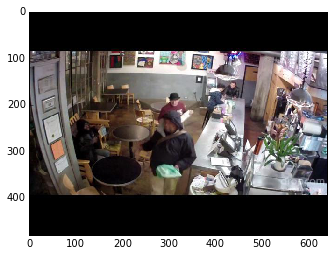

In [3]:
anno = idl[350]
img = imread('./data/brainwash/%s' % anno.imageName)
plt.imshow(img)

In [4]:
from utils.rect import Rect
import cv2
def add_rectangles(orig_image, confidences, boxes, arch, rnn_len=1):
    image = np.copy(orig_image[0])
    num_cells = arch["grid_height"] * arch["grid_width"]
    boxes_r = np.reshape(boxes, (arch["batch_size"],
                                 arch["grid_height"],
                                 arch["grid_width"],
                                 rnn_len,
                                 4))
    confidences_r = np.reshape(confidences, (arch["batch_size"],
                                             arch["grid_height"],
                                             arch["grid_width"],
                                             rnn_len,
                                             2))

    cell_pix_size = 32
    all_rects = [[[] for _ in range(arch["grid_width"])] for _ in range(arch["grid_height"])]
    for n in range(rnn_len):
        for y in range(arch["grid_height"]):
            for x in range(arch["grid_width"]):
                bbox = boxes_r[0, y, x, n, :]
                conf = confidences_r[0, y, x, n, 1]
                abs_cx = int(bbox[0]) + cell_pix_size/2 + cell_pix_size * x
                abs_cy = int(bbox[1]) + cell_pix_size/2 + cell_pix_size * y
                w = bbox[2]
                h = bbox[3]
                all_rects[y][x].append(Rect(abs_cx,abs_cy,w,h,conf))

#     acc_rects = [r for row in all_rects for cell in row for r in cell]
    acc_rects = stitch_rects(all_rects)


    for rect in acc_rects:
        if rect.confidence > 0.5:
            cv2.rectangle(image,
                (rect.cx-int(rect.width/2), rect.cy-int(rect.height/2)),
                (rect.cx+int(rect.width/2), rect.cy+int(rect.height/2)),
                (255,0,0),
                2)

    return image

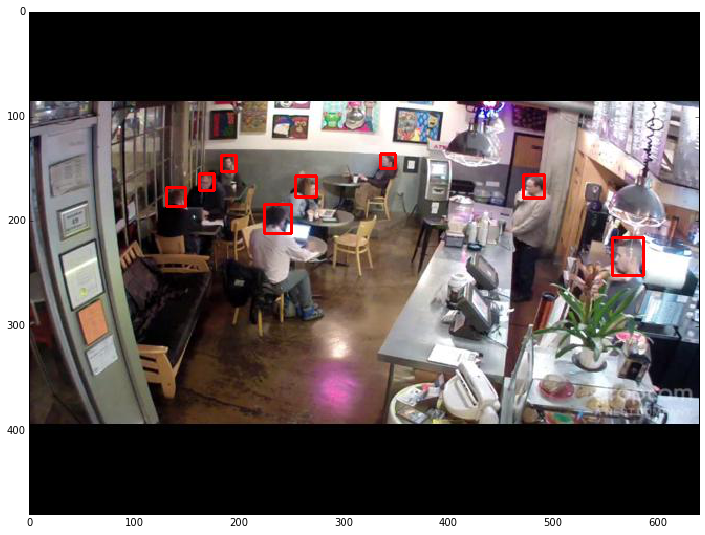

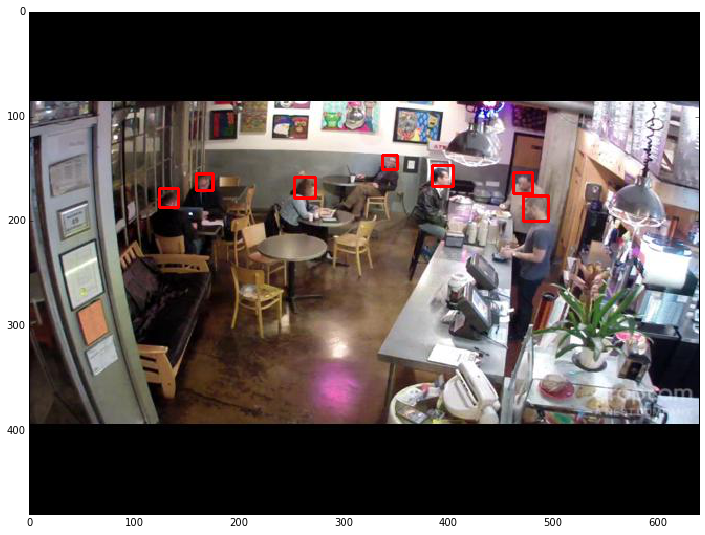

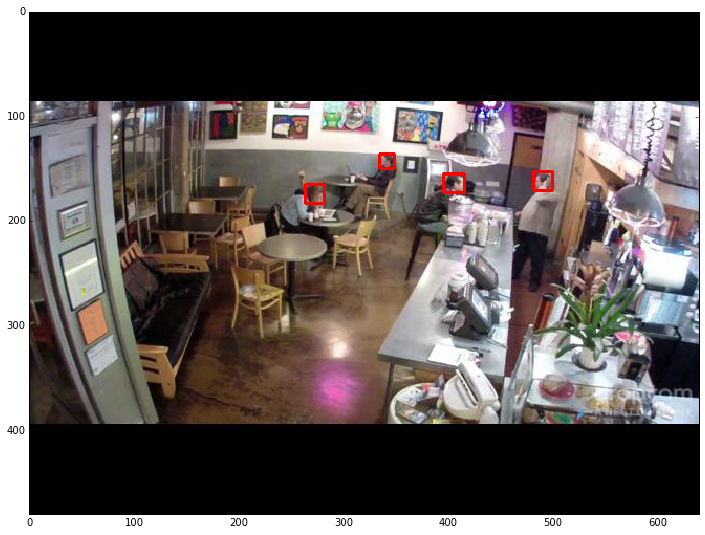

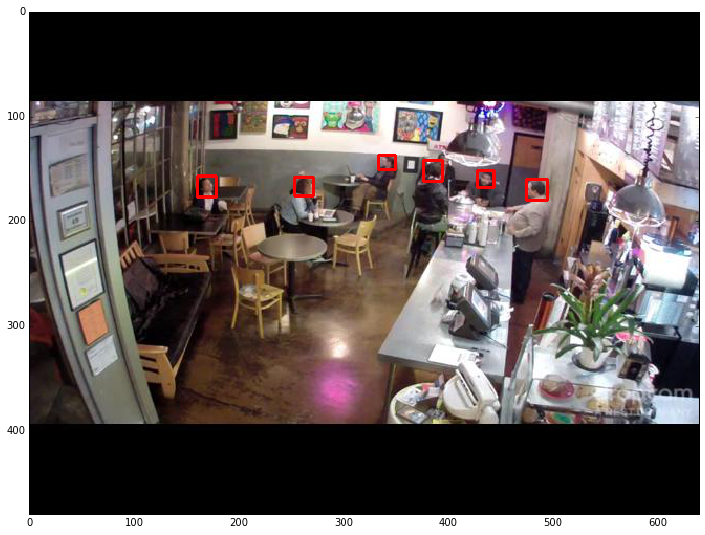

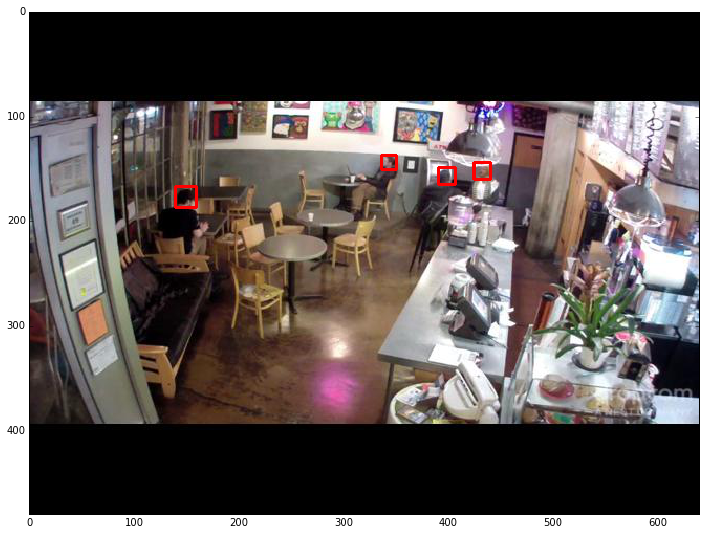

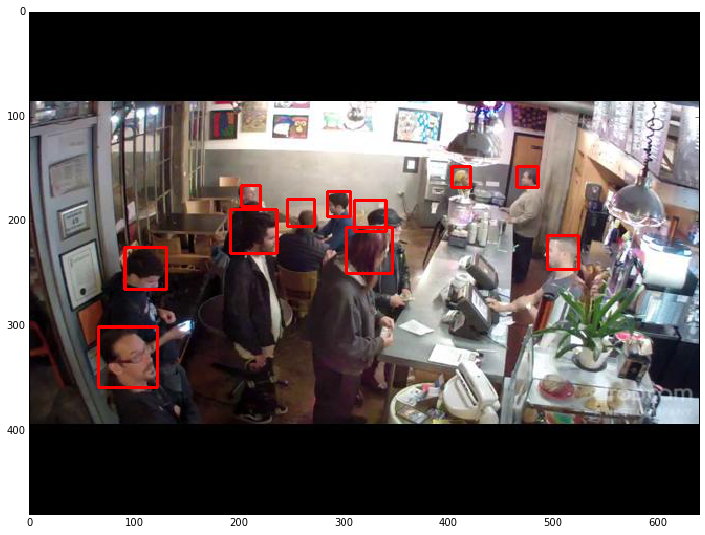

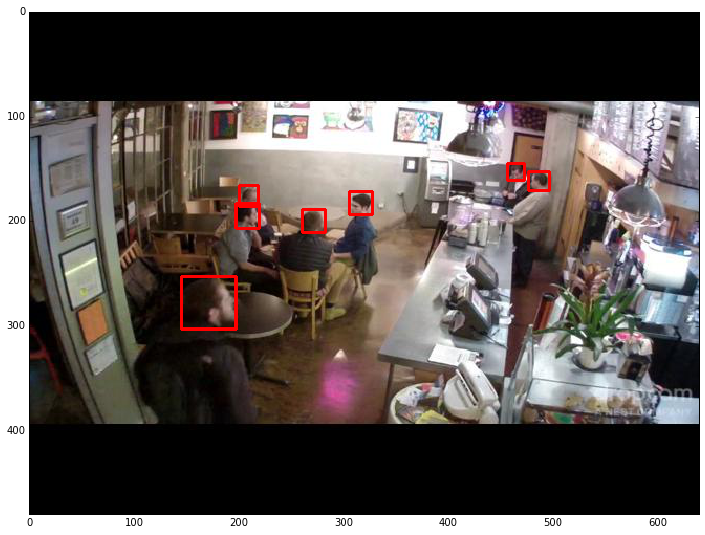

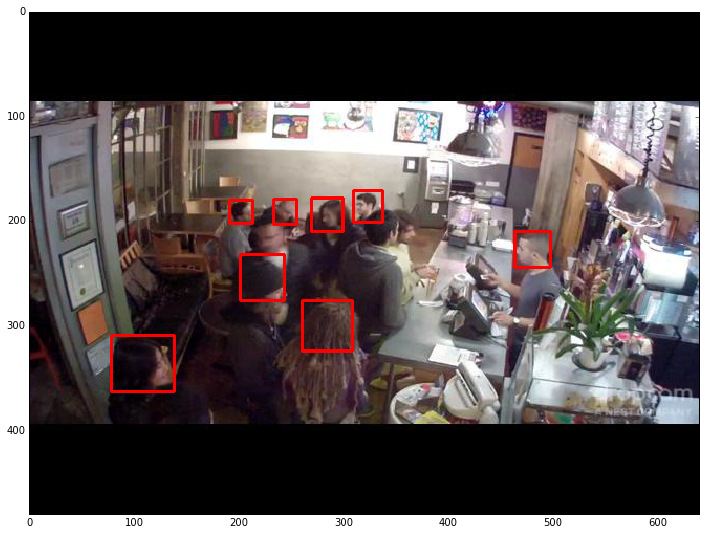

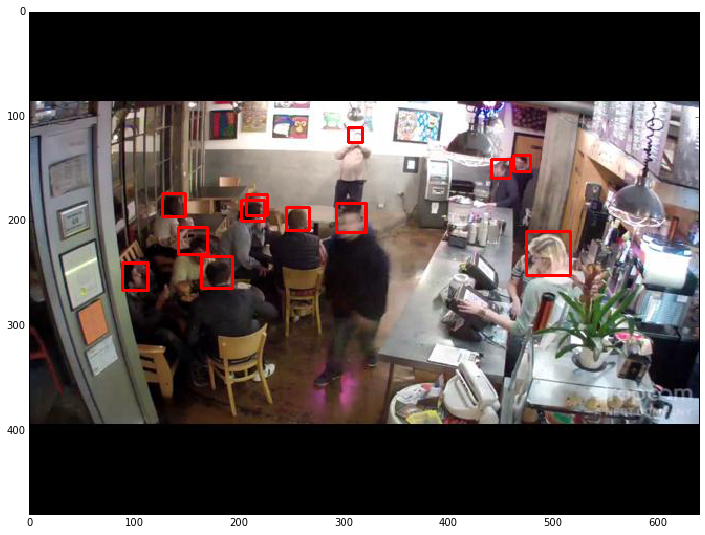

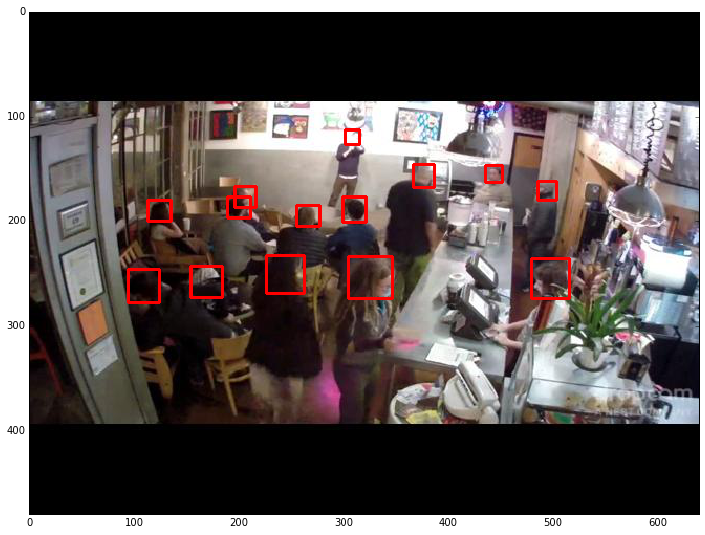

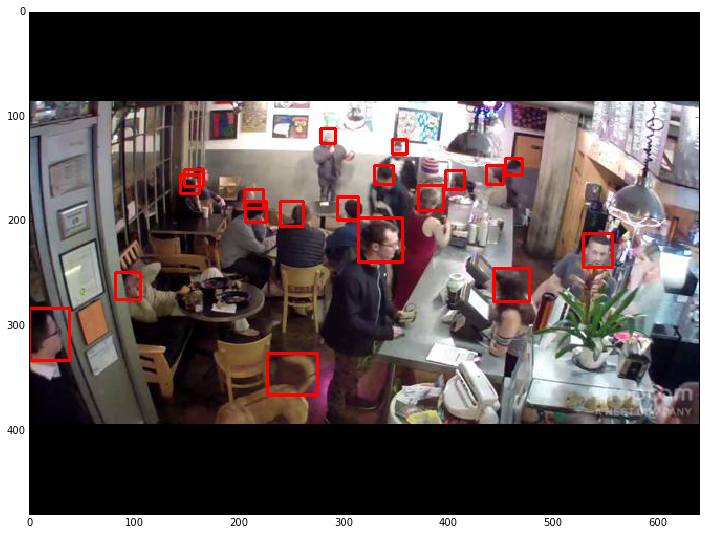

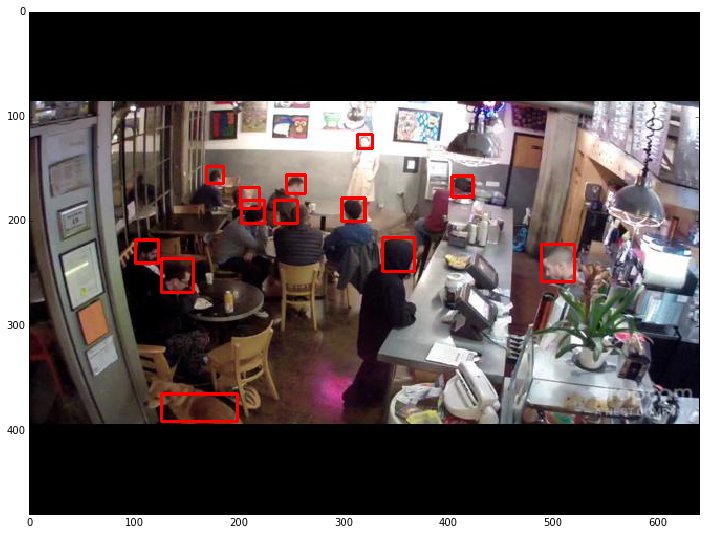

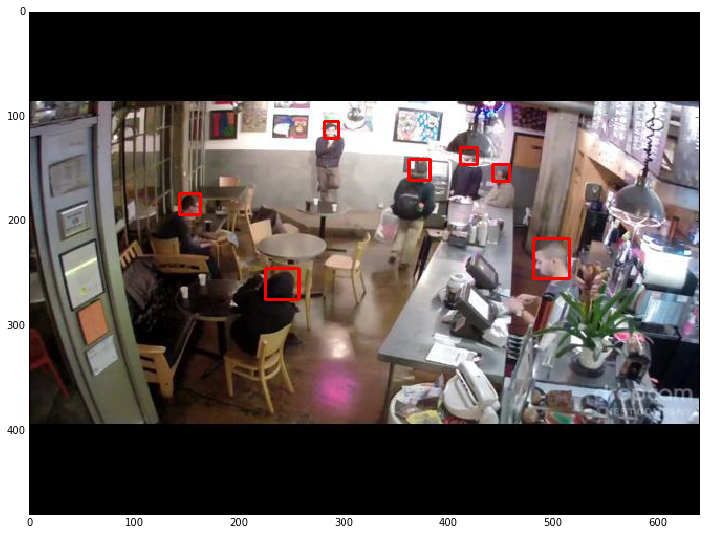

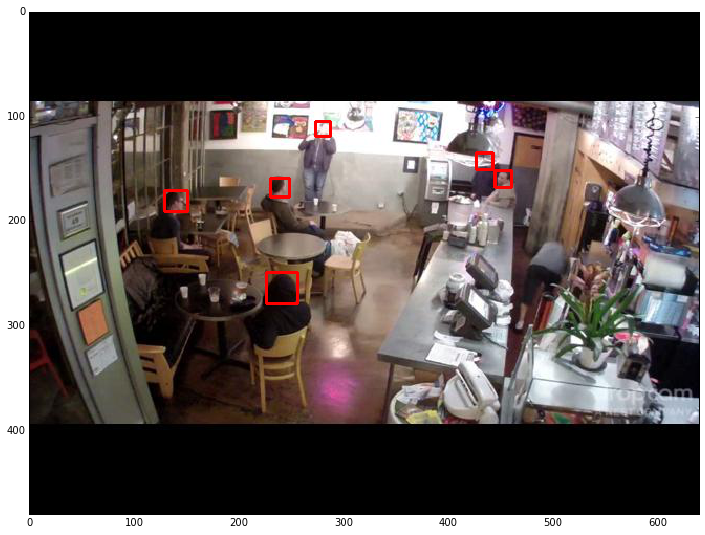

In [5]:
with open('./hypes/lstm2_100decay.json', 'r') as f:
    H = json.load(f)
tf.reset_default_graph()
googlenet = googlenet_load.init(H)
x_in = tf.placeholder(tf.float32, name='x_in')
if H['arch']['use_lstm']:
    pred_boxes, pred_logits, pred_confidences = build_lstm_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test', reuse=None)
else:
    pred_boxes, pred_logits, pred_confidences = build_overfeat_forward(H, tf.expand_dims(x_in, 0), googlenet, 'test')
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    if H['arch']['use_lstm']:
        saver.restore(sess, 'output/lstm2_100decay_2016_02_21_17.53/save.ckpt-320000')
    else:
        saver.restore(sess, 'output/default_2016_02_21_17.53/save.ckpt-100000')

    for i in range(3, 100, 7):
        anno = idl[i]
        img = imread('./data/brainwash/%s' % anno.imageName)
        feed = {x_in: img}
        (np_pred_boxes, np_pred_confidences) = sess.run([pred_boxes, pred_confidences], feed_dict=feed)
        new_img = add_rectangles([img], np_pred_confidences, np_pred_boxes, H["arch"], rnn_len=H['arch']['rnn_len'])

        fig = plt.figure(figsize=(12, 12))
        plt.imshow(new_img)